# **Transformaciones de los CSVs**

Tras el Análisis Exploratorio de Datos (EDA) en el primer notebook **(eda.ipynb)** hemos identificado varias columnas que requieren tratamiento para unificar los datos. Algunas columnas son redundantes o irrelevantes para nuestro objetivo de predecir la puntuación de felicidad, mientras que otras, aunque pueden servir, presentan dificultades para integrar debido a su inconsistencia entre datasets.

Aquí vamos a detallar lo que haremos según el análisis que realizamos en **eda.ipynb**

### 1. Columnas a **UTILIZAR** y su Estandarización:

Nos centraremos en un conjunto de características que son consistentes todos los datasets. Los nombres se estandarizarán a versiones cortas y consistentes:

*   `Country`: Identificador del país.
    *   *Origen*: `Country`, `Country or region`.
*   `Year`: Año del reporte.
    *   *Origen*: Se creará a partir del nombre del archivo/dataset.
*   `Score`: Puntuación de felicidad (nuestra **variable objetivo**).
    *   *Origen*: `Happiness Score`, `Happiness.Score`, `Score`.
*   `Economy`: Contribución del PIB per cápita al cálculo de la felicidad.
    *   *Origen*: `Economy (GDP per Capita)`, `Economy..GDP.per.Capita.`, `GDP per capita`.
*   `Support`: Contribución del soporte social (familia, amigos).
    *   *Origen*: `Family`, `Social support`.
*   `Health`: Contribución de la esperanza de vida saludable.
    *   *Origen*: `Health (Life Expectancy)`, `Health..Life.Expectancy.`, `Healthy life expectancy`.
*   `Freedom`: Contribución de la libertad para tomar decisiones de vida.
    *   *Origen*: `Freedom`, `Freedom to make life choices`.
*   `Trust`: Contribución de la percepción de corrupción en el gobierno y empresas.
    *   *Origen*: `Trust (Government Corruption)`, `Trust..Government.Corruption.`, `Perceptions of corruption`.
*   `Generosity`: Contribución de la generosidad.
    *   *Origen*: `Generosity` (generalmente consistente).
*   `Region`: Región geográfica del país.
    *   *Origen*: Presente en datasets 2015 y 2016. Se propagará a los demás.

**Nota**: Esto lo hacemos para mantener consistencia y el modelo pueda predecir mejor los datos, sin tener la misma feature pero con un nombre distinto

### 2. Columnas a **DESCARTAR** y el Porqué:

Las siguientes columnas las vamos a omitir:

*   `Happiness Rank` / `Overall rank`: Es un resultado directo del `Score` y no una causa. Incluirlo sería un problema para la predicción.
*   `Standard Error`, `Lower Confidence Interval`, `Upper Confidence Interval`, `Whisker.high`, `Whisker.low`: Estas columnas representan la incertidumbre estadística o los intervalos de confianza alrededor del `Score`. Aunque informativas sobre la precisión de la medición original, no son características predictivas directas del `Score` en sí mismo para un nuevo país o año. Además, no son consistentes en todos los datasets.
*   `Dystopia Residual`: Es esencialmente: **Score – (GDP per capita + Support + Health + Freedom + Trust + Generosity)**, por lo que es una feature que depende del Score, y la vamos a eliminar **(esto se explico en el notebook 001_eda.ipynb)**

### 3. Estrategias

*   **Adición de `Year`**: Se creará una columna `Year` en cada dataset individual antes de la concatenación, tomando el valor del año del reporte (2015 a 2019).
*   **Integración de `Region`**:
    1.  Se tomarán los datos de `Country` y `Region` de los datasets 2015 y 2016.
    2.  Se creará un diccionario o Serie de Pandas (`Country` -> `Region`) único.
    3.  Este mapeo se usará para rellenar la columna `Region` en los datasets 2017, 2018 y 2019, haciendo un `map` o `merge` sobre la columna `Country`.
    4.  Los países que no se encuentren en el mapeo (y por ende resulten en `NaN` en `Region`) serán analizados. Se podría asignar una categoría como "Unknown" o podemos buscar de manera manual a que region pertenece el país.
*   **Concatenación**: Todos los datasets, una vez con columnas renombradas, `Year` y `Region` añadidas, y columnas irrelevantes descartadas, se unirán en un único DataFrame `merge_df`.
*   **Manejo de Valores Nulos Post-Unificación**:
    *   El valor nulo identificado en `Trust` (antes `Perceptions of corruption`) para UAE en 2018 se tratará.
    *   Cualquier `NaN` en `Region` también se abordará.

In [2]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data_path = '../data/'
csv_files = {year: os.path.join(data_path, f'{year}.csv') for year in ['2015', '2016', '2017', '2018', '2019']}
dfs = {year: pd.read_csv(filepath) for year, filepath in csv_files.items()}

In [4]:
final_features = {
    'Country': 'Country', 'Score': 'Score', 'Economy': 'Economy',
    'Support': 'Support', 'Health': 'Health', 'Freedom': 'Freedom',
    'Trust': 'Trust', 'Generosity': 'Generosity'
}

rename_maps = {
    '2015': {
        'Happiness Score': 'Score', 'Economy (GDP per Capita)': 'Economy',
        'Family': 'Support', 'Health (Life Expectancy)': 'Health',
        'Trust (Government Corruption)': 'Trust'
    },
    '2016': {
        'Happiness Score': 'Score', 'Economy (GDP per Capita)': 'Economy',
        'Family': 'Support', 'Health (Life Expectancy)': 'Health',
        'Trust (Government Corruption)': 'Trust'
    },
    '2017': {
        'Happiness.Score': 'Score', 'Economy..GDP.per.Capita.': 'Economy',
        'Family': 'Support', 'Health..Life.Expectancy.': 'Health',
        'Trust..Government.Corruption.': 'Trust'
    },
    '2018': {
        'Country or region': 'Country', 'Score': 'Score',
        'GDP per capita': 'Economy', 'Social support': 'Support',
        'Healthy life expectancy': 'Health', 'Freedom to make life choices': 'Freedom',
        'Perceptions of corruption': 'Trust'
    },
    '2019': {
        'Country or region': 'Country', 'Score': 'Score',
        'GDP per capita': 'Economy', 'Social support': 'Support',
        'Healthy life expectancy': 'Health', 'Freedom to make life choices': 'Freedom',
        'Perceptions of corruption': 'Trust'
    }
}

Seleccionamos las columnas que vamos a necesitar, y **mapeamos** algunas de los diferentes datasets para que tengan el mismo nombre a la hora de hacer el **merge** de estos **5 CSV**

In [5]:
temp_dfs_processed = {}
for year_str, df_original in dfs.items():
    df_copy = df_original.copy()
    df_copy.rename(columns=rename_maps.get(year_str, {}), inplace=True)
    df_copy['Year'] = int(year_str)
    temp_dfs_processed[year_str] = df_copy

Lo que hace el bloque anterior es:

+  inicializa un diccionario **temp_dfs_processed** para almacenar los datasets procesados por año. Para cada año **(2015-2019)**
+ Se crea una copia del DataFrame original para evitar modificaciones directas 
+ Se renombran las columnas según el diccionario rename_maps **(basado en las diferencias identificadas en EDA)**
+ Por último agrega la columna Year con el valor correspondiente. Esto asegura que los datos tengan nombres uniformes y un identificador temporal

In [6]:
df_2015_processed = temp_dfs_processed['2015']
df_2016_processed = temp_dfs_processed['2016']

region_map_2015 = df_2015_processed[['Country', 'Region']].drop_duplicates()
region_map_2016 = df_2016_processed[['Country', 'Region']].drop_duplicates()
country_to_region_map = pd.concat([region_map_2015, region_map_2016]).drop_duplicates(subset=['Country'], keep='first').set_index('Country')['Region']

**El bloque anterior crea un mapeo de países a regiones utilizando los datasets de 2015 y 2016**

+ la columna Region está presente **(Falta en 2017-2019)**. 
+ Se extraen las columnas Country y Region, 
+ se eliminan duplicados, se combinan ambos años
+ se establece un índice único por país. 

Esto mantener consistente las regiones a los datasets posteriores, teniendo en cuenta que esta columna **no se encuentra presente en todos los CSVs**

In [7]:
columns_for_merge_df = ['Country', 'Year', 'Region'] + [col_value for col_key, col_value in final_features.items() if col_key != 'Country']
list_of_dfs_to_concat = []

for year_identifier, processed_df in temp_dfs_processed.items():
    current_df = processed_df.copy()
    if 'Region' not in current_df.columns:
        current_df['Region'] = current_df['Country'].map(country_to_region_map)
    
    selected_columns_for_current_df = [col for col in columns_for_merge_df if col in current_df.columns]
    list_of_dfs_to_concat.append(current_df[selected_columns_for_current_df])

merge_df = pd.concat(list_of_dfs_to_concat, ignore_index=True)
merge_df = merge_df[columns_for_merge_df] 

**El bloque anterior prepara los datos para unirlos en un solo DataFrame**

+ Define las columnas finales **(Country, Year, Region y las variables estandarizadas de final_features)**, excluyendo duplicados. 
+ Para cada año, se copia el DataFrame procesado 
+ se agrega la columna Region usando el mapeo si no existe (resolviendo la falta en 2017-2019) 
+ se seleccionan solo las columnas presentes en cada dataset para evitar errores. 

**Los DataFrames se almacenan en una lista para concatenación, asegurando compatibilidad entre años.**

**La parte de:**

```
merge_df = pd.concat(list_of_dfs_to_concat, ignore_index=True)

merge_df = merge_df[columns_for_merge_df]
```

Combina todos los DataFrames procesados en un solo DataFrame (merge_df) usando pd.concat, reiniciando los índices para evitar duplicados. Luego, se reordena y filtra para incluir solo las columnas definidas **(columns_for_merge_df)**

In [8]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Country     782 non-null    object 
 1   Year        782 non-null    int64  
 2   Region      774 non-null    object 
 3   Score       782 non-null    float64
 4   Economy     782 non-null    float64
 5   Support     782 non-null    float64
 6   Health      782 non-null    float64
 7   Freedom     782 non-null    float64
 8   Trust       781 non-null    float64
 9   Generosity  782 non-null    float64
dtypes: float64(7), int64(1), object(2)
memory usage: 61.2+ KB


In [9]:
missing_regions = merge_df[merge_df['Region'].isnull()][['Country', 'Year']].drop_duplicates()
print(missing_regions)

missing_countries = missing_regions['Country'].unique()
for country in missing_countries:
    if country in country_to_region_map.index:
        print(f"{country}: Región encontrada - {country_to_region_map[country]}")

                      Country  Year
347  Taiwan Province of China  2017
385   Hong Kong S.A.R., China  2017
507         Trinidad & Tobago  2018
527           Northern Cyprus  2018
664         Trinidad & Tobago  2019
689           Northern Cyprus  2019
709           North Macedonia  2019
745                    Gambia  2019


**Nos damos cuenta de que hay países que no tienen un región asignada**
+ Considerando esto, agregaremos las regiones manualmente

In [10]:
manual_region_corrections = {
    'Taiwan Province of China': 'Eastern Asia',
    'Hong Kong S.A.R., China': 'Eastern Asia',
    'Trinidad & Tobago': 'Latin America and Caribbean',
    'Northern Cyprus': 'Western Europe',
    'North Macedonia': 'Central and Eastern Europe',
    'Gambia': 'Sub-Saharan Africa'
}

for country_name_fix, region_name_fix in manual_region_corrections.items():
    merge_df.loc[merge_df['Country'] == country_name_fix, 'Region'] = region_name_fix

median_trust_value = merge_df['Trust'].median()
merge_df.loc[merge_df['Trust'].isnull(), 'Trust'] = median_trust_value

Una parte del bloque anterior agrega a los países sus regiones correspondientes.

Y la parte del código de:

```
median_trust_value = merge_df['Trust'].median()

merge_df.loc[merge_df['Trust'].isnull(), 'Trust'] = median_trust_value

```

**maneja el valor nulo** detectado en **Trust** en Emiratos Arabes Unidos en el **csv de 2018**. Calcula la mediana de Trust como un valor representativo y la usa para imputar los valores faltantes

In [11]:
print(merge_df.isnull().sum())

Country       0
Year          0
Region        0
Score         0
Economy       0
Support       0
Health        0
Freedom       0
Trust         0
Generosity    0
dtype: int64


In [12]:
merge_df.head()

,Country,Year,Region,Score,Economy,Support,Health,Freedom,Trust,Generosity
0,Switzerland,2015,Western Europe,7.587,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678
1,Iceland,2015,Western Europe,7.561,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630
2,Denmark,2015,Western Europe,7.527,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139
3,Norway,2015,Western Europe,7.522,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699
4,Canada,2015,North America,7.427,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811


In [13]:
output_file_path = os.path.join(data_path, 'merge_happiness.csv')
merge_df.to_csv(output_file_path, index=False)
print(f"DataFrame guardado en: {output_file_path}")

DataFrame guardado en: ../data/merge_happiness.csv


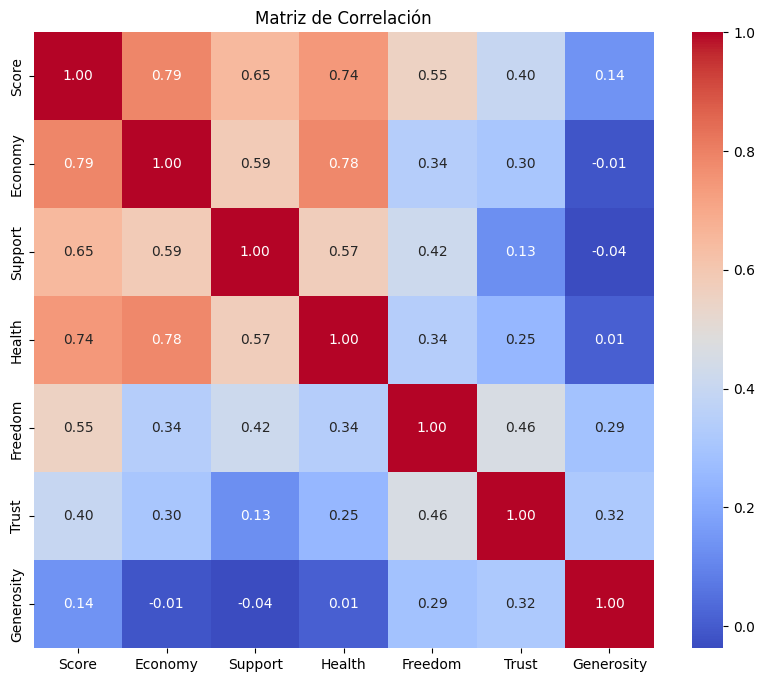

In [14]:
numeric_columns = ['Score', 'Economy', 'Support', 'Health', 'Freedom', 'Trust', 'Generosity']
correlation_matrix = merge_df[numeric_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

# Análisis de la Matriz de Correlación del Dataset Combinado


### Correlaciones con *Score* (Puntuación de felicidad):

- **Economy (0.79)**: Existe una correlación fuerte y positiva. El Producto Interno Bruto (PIB) per cápita es un factor clave en la felicidad, donde los países más ricos tienden a tener puntuaciones más altas.
- **Health (0.74)**: También se observa una fuerte correlación. La esperanza de vida saludable tiene un impacto significativo en la felicidad.
- **Support (0.65)**: Correlación moderada a fuerte. El apoyo social, proveniente de redes de familia y amigos, contribuye bastante a la felicidad.
- **Freedom (0.55)**: Correlación moderada. La libertad para tomar decisiones de vida es relevante, pero no tan dominante como la economía o la salud.
- **Trust (0.40)**: Correlación débil a moderada. La confianza en el gobierno (o la percepción de corrupción) tiene un efecto positivo, pero es menos influyente en comparación con otros factores.
- **Generosity (0.14)**: Correlación muy débil. La generosidad no parece ser un predictor relevante de la felicidad.

### Correlaciones entre *Economy* y *Health* (0.78):
La fuerte correlación entre estos dos factores, nos dice que los países más ricos tienden a tener sistemas de salud más avanzados.

### Insight:
En el dataset, los principales impulsores de la felicidad son la economía, la salud y el apoyo social. En cambio, la generosidad y la confianza en el gobierno no son tan importantes en la felicidad a nivel global.


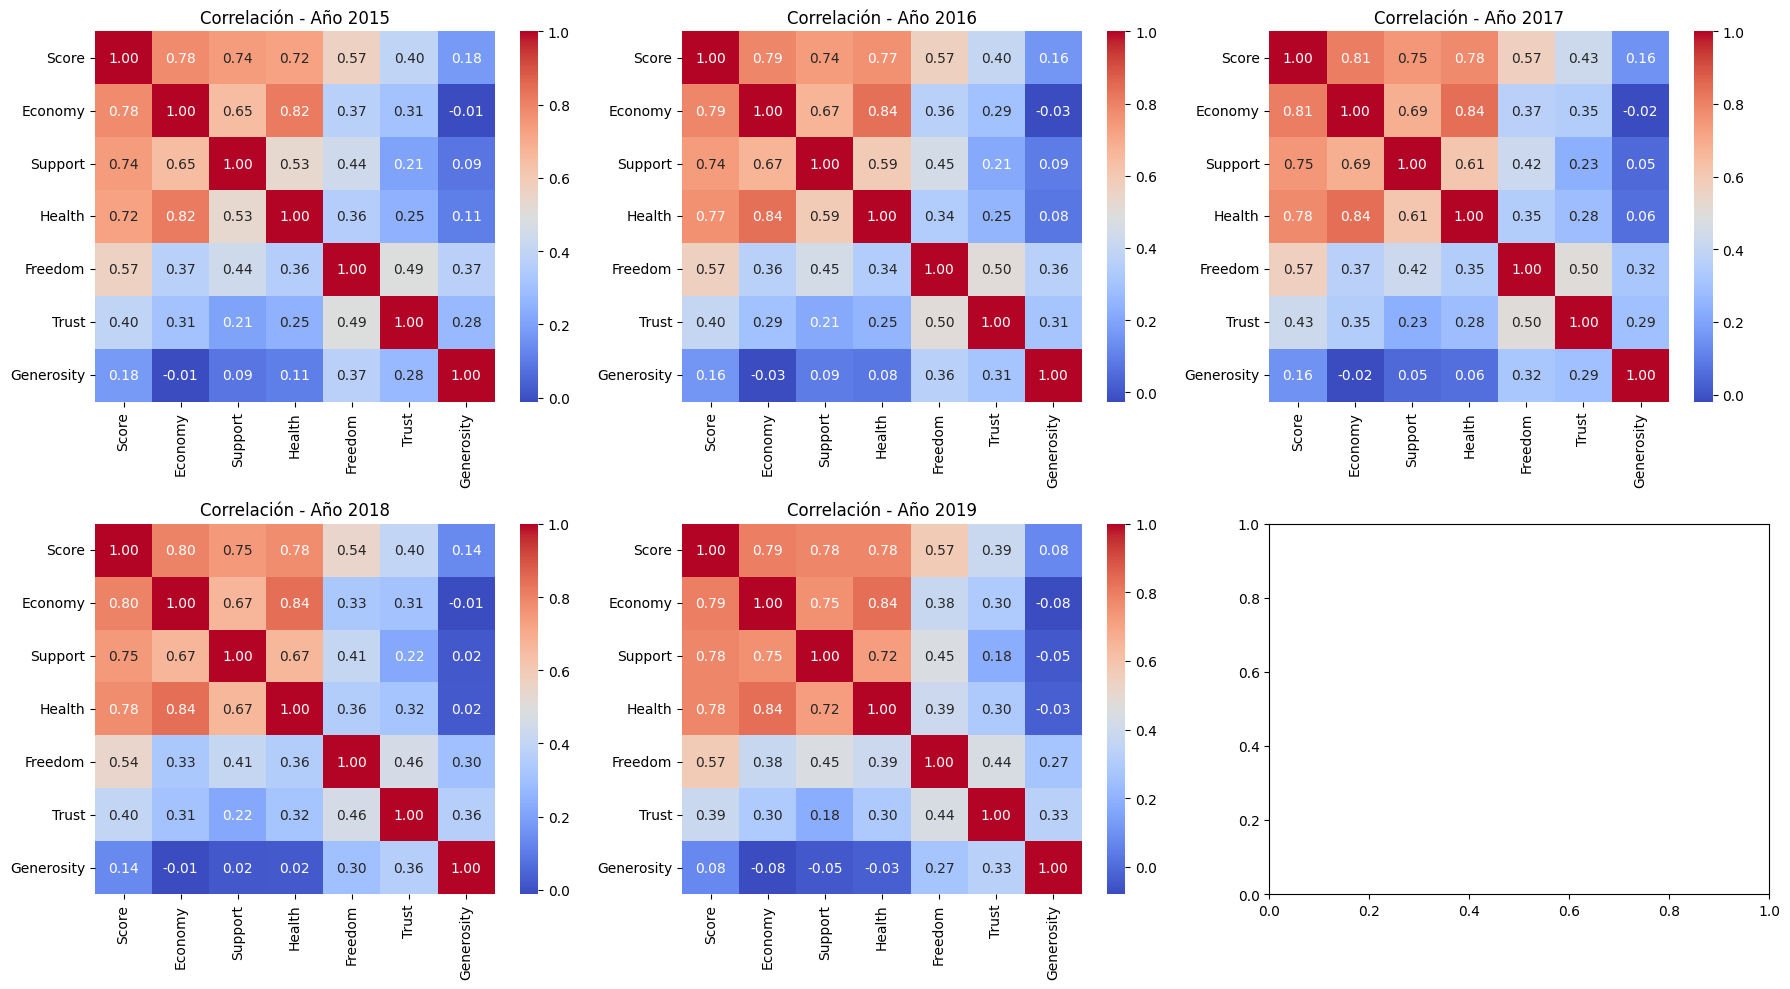

In [15]:
years = merge_df['Year'].unique()

# Crear subplots para cada año
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, year in enumerate(years):
    df_year = merge_df[merge_df['Year'] == year]
    
    corr_matrix = df_year[numeric_columns].corr()
    
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[i])
    axes[i].set_title(f'Correlación - Año {year}')

plt.tight_layout()
plt.show()

# Observaciones

- **Estabilidad**: Las correlaciones se mantienen estables a lo largo de los años.
  - **Score y Economy**: La relación entre la felicidad y la economía siempre se mantiene fuerte, con un valor entre **0.78 y 0.81**.
  - **Score y Health**: También se observa una correlación fuerte y estable, con valores que oscilan entre **0.72 y 0.78**.
  - **Score y Support**: La relación entre la felicidad y el apoyo social varía entre **moderada y fuerte**, con valores entre **0.74 y 0.78**.

### Variaciones Sutiles

- **Score y Trust**: La correlación con la confianza es baja (alrededor de **0.40**), aunque sube ligeramente en los años **2017 (0.43)** y **2018 (0.40)**.
- **Support y Freedom**: Se nota un pequeño aumento en la correlación en **2019 (0.42)** en comparación con **2015 (0.34)**.

### Correlaciones Negativas

- **Generosity y Economy**: La correlación entre generosidad y economía es muy débil y negativa, oscilando entre **-0.01 a -0.08**, lo que sugiere que los países más ricos no son necesariamente más generosos.


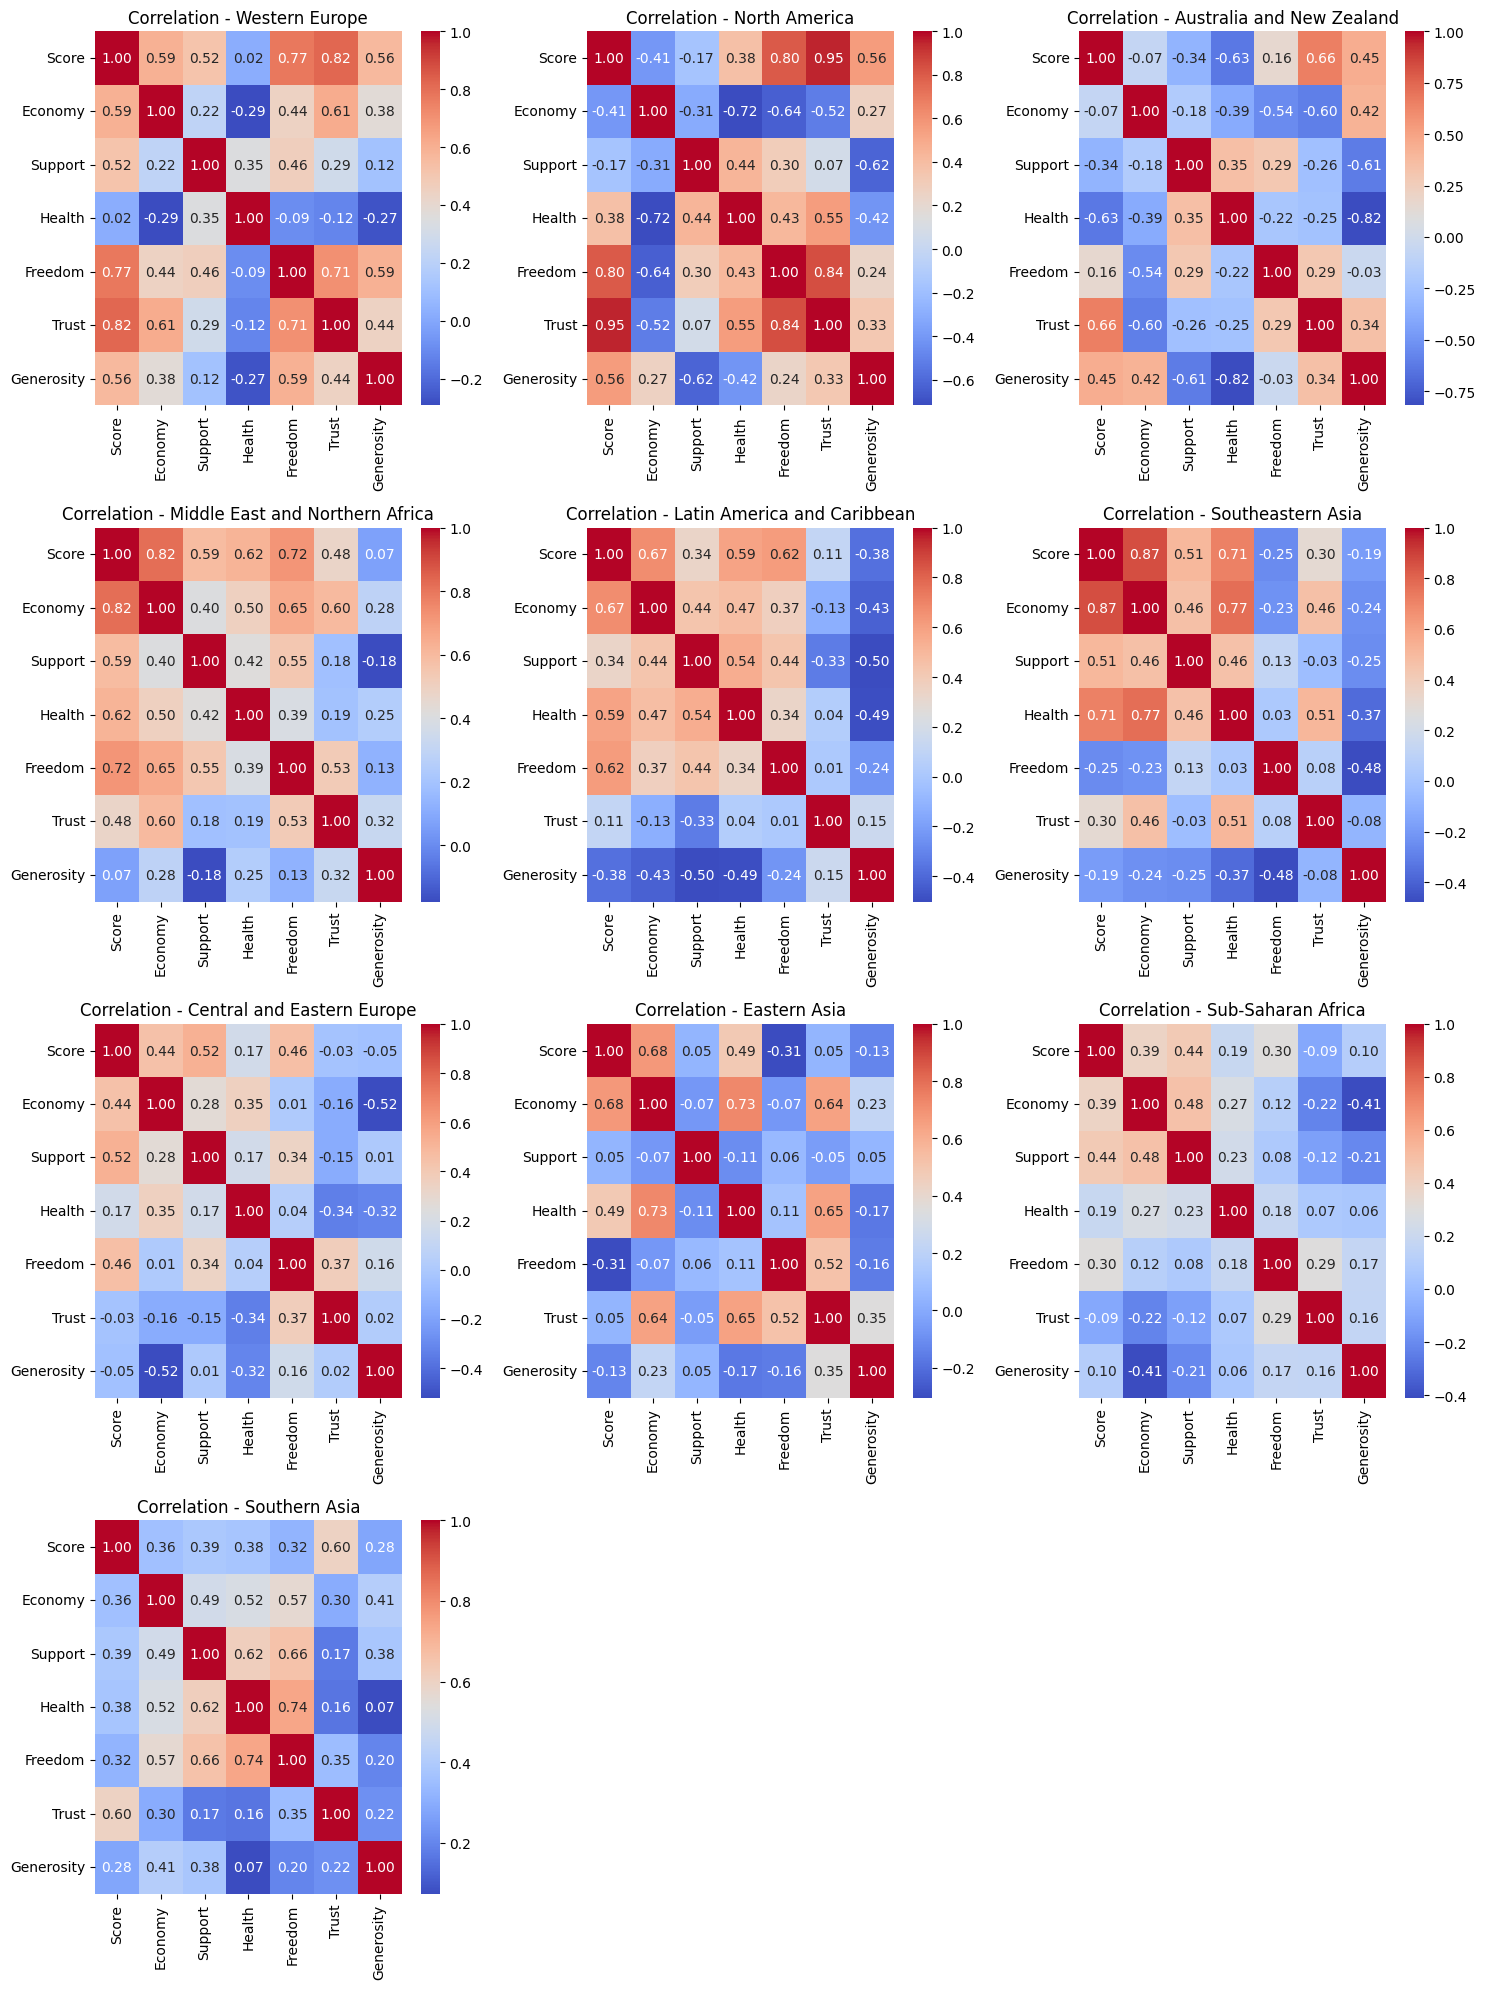

In [16]:
regions = merge_df['Region'].unique()
n_regions = len(regions)
n_cols = 3
n_rows = (n_regions + n_cols - 1) // n_cols
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()
numeric_columns = ['Score', 'Economy', 'Support', 'Health', 'Freedom', 'Trust', 'Generosity']

for i, region in enumerate(regions):
    df_region = merge_df[merge_df['Region'] == region]
    corr_matrix = df_region[numeric_columns].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[i])
    axes[i].set_title(f'Correlation - {region}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Insights por Región

### Europa Occidental

* **Score y Libertad (0.77):** Tener autonomía para decidir es clave para la felicidad.
* **Score y Confianza (0.52):** La confianza en el gobierno influye, pero no es lo principal.
* **Score y Economía (0.59):** La economía importa, aunque menos que en promedio global; aquí pesa más la libertad y el apoyo social.
* **Interacciones:**

  * *Libertad y Confianza (0.71):* Países con más libertad suelen tener gobiernos más confiables.
  * *Economía y Salud (-0.29):* Curioso: más riqueza no siempre significa mejor salud.
* **Insight:** En Europa Occidental, la felicidad se impulsa principalmente con libertad y apoyo social, más que con economía o confianza en el gobierno.

### Norteamérica

* **Score y Confianza (0.95):** La confianza en el gobierno es vital para la felicidad en EE.UU. y Canadá.
* **Score y Libertad (0.80):** La libertad también tiene gran peso.
* **Score y Economía (-0.41):** Impacto negativo inesperado; tal vez por pocas muestras o porque la riqueza no siempre garantiza felicidad.
* **Interacciones:**

  * *Confianza y Libertad (0.64):* Gobiernos confiables suelen promover más libertad.
  * *Economía y Salud (0.72):* Más riqueza, mejor salud.
* **Insight:** Aquí, la felicidad depende más de confianza y libertad, mientras que la economía tiene menor influencia.

### Australia y Nueva Zelanda

* **Score y Confianza (0.66):** La confianza en el gobierno influye bastante en la felicidad.
* **Score y Salud (-0.63):** Mejor salud no siempre significa más felicidad.
* **Score y Generosidad (-0.45):** La generosidad no suma para la felicidad en esta región.
* **Interacciones:**

  * *Economía y Salud (-0.39):* Riqueza y salud no siempre van de la mano.
  * *Confianza y Libertad (0.29):* Relación baja, menos marcada que en otras partes.
* **Insight:** La confianza ayuda a la felicidad, pero la salud y generosidad tienen poco o hasta impacto negativo, probablemente por factores culturales.

### Medio Oriente y Norte de África

* **Score y Libertad (0.72):** La libertad es lo más importante para la felicidad, mostrando un deseo fuerte de autonomía.
* **Score y Economía (0.62):** La economía también juega un papel importante.
* **Score y Confianza (0.48):** La confianza en el gobierno tiene un efecto moderado.
* **Interacciones:**

  * *Libertad y Economía (0.65):* Países más ricos suelen ofrecer más libertad.
  * *Economía y Salud (0.50):* Riqueza relacionada con mejor salud.
* **Insight:** La felicidad depende sobre todo de libertad y economía, con la confianza en segundo plano.

### América Latina y el Caribe

* **Score y Economía (0.67):** La economía es el factor principal para la felicidad.
* **Score y Salud (0.58):** La salud también tiene mucho peso.
* **Score y Confianza (0.11):** La confianza en el gobierno es muy baja, probablemente por corrupción percibida.
* **Interacciones:**

  * *Economía y Salud (0.47):* Más riqueza, mejor salud.
  * *Confianza y Libertad (0.04):* Casi no hay relación entre estos dos.
* **Insight:** La economía y salud impulsan la felicidad; la confianza en el gobierno casi no cuenta.

### Sudeste Asiático

* **Score y Economía (0.87):** La correlación más alta, el desarrollo económico es clave.
* **Score y Salud (0.71):** La salud también pesa bastante.
* **Score y Confianza (0.30):** La confianza tiene poco impacto.
* **Interacciones:**

  * *Economía y Salud (0.77):* Riqueza y salud van muy de la mano.
  * *Libertad y Confianza (-0.37):* Más libertad no implica gobiernos más confiables.
* **Insight:** La felicidad va con desarrollo económico y salud, mientras confianza y libertad quedan en segundo plano.

### Europa Central y del Este

* **Score y Libertad (0.46):** Libertad tiene un impacto moderado, siendo lo más importante aquí.
* **Score y Economía (0.44):** La economía también influye, aunque menos.
* **Score y Confianza (0.03):** La confianza no tiene peso significativo.
* **Interacciones:**

  * *Economía y Salud (0.35):* Positiva pero baja.
  * *Confianza y Libertad (0.37):* Relación moderada.
* **Insight:** Libertad y economía son clave; la confianza no suma mucho.

### Asia Oriental

* **Score y Economía (0.68):** Economía es el factor más importante.
* **Score y Salud (0.49):** Salud tiene impacto moderado.
* **Score y Libertad (-0.31):** La libertad influye negativamente; no es clave.
* **Score y Confianza (-0.05):** La confianza no aporta a la felicidad.
* **Interacciones:**

  * *Economía y Salud (0.73):* Más riqueza, mejor salud.
  * *Libertad y Confianza (-0.55):* Más libertad está relacionada con menos confianza.
* **Insight:** La felicidad depende sobre todo de economía y salud; libertad y confianza tienen poco o impacto negativo.

### África Subsahariana

* **Score y Apoyo Social (0.44):** El apoyo social es lo más importante para la felicidad.
* **Score y Economía (-0.39):** Riqueza no siempre trae felicidad.
* **Score y Confianza (-0.09):** La confianza no es relevante.
* **Interacciones:**

  * *Economía y Salud (0.27):* Baja correlación.
  * *Apoyo y Libertad (0.08):* Casi no relacionados.
* **Insight:** El apoyo social es lo que más impulsa la felicidad; economía y confianza tienen impacto bajo o negativo.

### Asia Meridional

* **Score y Confianza (0.60):** La confianza en el gobierno tiene buen impacto.
* **Score y Economía (0.36):** La economía influye algo.
* **Score y Libertad (0.32):** La libertad tiene menor efecto.
* **Interacciones:**

  * *Economía y Salud (0.52):* Más riqueza se asocia a mejor salud.
  * *Libertad y Confianza (0.35):* Más libertad suele ir con gobiernos más confiables.
* **Insight:** La confianza es clave, seguida por economía y libertad, aunque ninguna con impacto fuerte.

---

# Conclusión General

Las correlaciones varían bastante según la región, reflejando diferencias culturales, sociales y económicas:

* **Regiones desarrolladas** (Norteamérica, Europa Occidental): La confianza y la libertad son los principales motores.
* **Regiones en desarrollo** (Sudeste Asiático, América Latina): Economía y salud mandan.
* **Regiones con más retos** (África Subsahariana): El apoyo social es fundamental; economía y confianza pesan poco o hasta afectan negativamente.

---